In [1]:
# execute this cell to install dependencies in the current environment
# useful when using Google Colab notebooks
%pip install sf-hamilton[visualization] requests openai lancedb burr[start,opentelemetry] pydantic pyarrow opentelemetry-instrumentation-openai opentelemetry-instrumentation-lancedb

/home/tjean/projects/dagworks/burr/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


# Use the 2-layer approach for a maintainable RAG system [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/burr/blob/main/examples/hamilton-integration/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/burr/blob/main/examples/hamilton-integration/notebook.ipynb)

Ready-made solutions can get you started with GenAI, but building reliable product features with retrieval augmented generation (RAG) and LLM agents inevitably required custom code. This post shares the 2-layer approach to build a maintainable RAG application that will evolve with your needs. To illustrate these ideas, we will show how a typical RAG project might evolve.

The 2-layer approach is about separating the high-level logic of your application from its implementation details. In Burr, the separation is represented by the `Application` (high-level) and the `action` (low-level). Over the lifetime of your product, you will iterate on both at different times.


In [2]:
# execute to load the Burr and Hamilton extensions
%load_ext burr.integrations.notebook
%load_ext hamilton.plugins.jupyter_magic

In [4]:
# set your OpenAI API key
import os
os.environ["OPENAI_API_KEY"] = "..."

## V1: A simple LLM pipeline
### Layer 2: Define the `Application` logic

Maybe counter-inuitively, you should start with the high-level logic, the layer 2, to determine how your application should behave. For instance:

1. actions: what are the things your application can do?
2. transitions & conditions: when should an action be performed?
3. inputs, results, & state: what data is required to execute an action or to decide which action to perform?

Skipping these initial questions usually leads to refactoring and slows down development.

In the next snippet, we build a simple application that ingests a blog post and allows to ask questions over its content. We outline our application logic without writing the body of the `@action` functions (level 2) and build it with the `ApplicationBuilder` to view the graph.

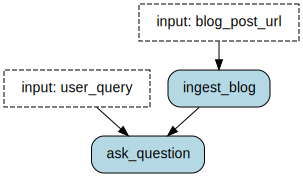

In [5]:
from burr.core import action, State, ApplicationBuilder

# `reads` and `writes` specify what data is read/written via the `State`.
@action(reads=[], writes=["blog_content"])
def ingest_blog(state: State, blog_post_url: str) -> State:
    """Download a blog post and parse it"""
    blog_content = ...
    return state.update(blog_content=blog_content)


@action(reads=["blog_content", "history"], writes=["history"])
def ask_question(state: State, user_query: str) -> State:
    """Reply to the user's query using the blog's content."""
    history = state["history"]
    blog_content = state["blog_content"]
    response = ...
    return state.append(history=response)


# the `ApplicationBuilder` receives the actions,
# specifies the transitions, and sets the starting action.
(
    ApplicationBuilder()
    .with_actions(ingest_blog, ask_question)
    .with_transitions(("ingest_blog", "ask_question"))
    .with_entrypoint("ingest_blog")
    .build()
)

This outline sets "contracts" for the role and input/output of each actions. As you implement individual actions, you might decide to merge/split actions, modify state variables, etc. Then, you can revisit and update your application outline.

### Layer 1: Implement individual `@action`

At the start of our project, with might come up with this simple `Application`:
1. `ingest_blog` downloads an HTML page, parses it into a plain text.
2. `ask_question` prompts an OpenAI LLM with the full blog in the prompt and the user query.

By using "plain" Python libraries instead of LLM frameworks, it will be easier to find bugs and modify our code as our application needs evolve.

In [6]:
import requests
import openai
from bs4 import BeautifulSoup
from burr.core import action, State, ApplicationBuilder


@action(reads=[], writes=["blog_content"])
def ingest_blog_v1(state: State, blog_post_url: str) -> State:
    """Download a blog post and parse it"""
    html_content = requests.get(blog_post_url).text
    soup = BeautifulSoup(html_content, "html.parser")
    blog_content = soup.get_text(separator=" ", strip=True)
    return state.update(blog_content=blog_content)


@action(reads=["blog_content"], writes=["llm_answer"])
def ask_question_v1(state: State, user_query: str) -> State:
    """Reply to the user's query using the blog's content."""
    blog_content = state["blog_content"]

    system_prompt = (
        "Answer the user's questions based on the provided blog post content. "
        "Answer in a concise and helpful manner, and tell the user "
        "if you don't know the answer or you're unsure.\n\n"
        f"BLOG CONTENT:\n{blog_content}"
    )

    client = openai.OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_query}
        ],
    )
    llm_answer = response.choices[0].message.content
    return state.update(llm_answer=llm_answer)

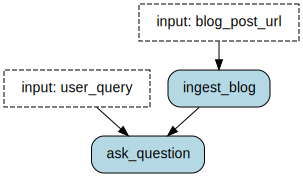

In [7]:
app_v1 = (
    ApplicationBuilder()
    .with_actions(ingest_blog=ingest_blog_v1, ask_question=ask_question_v1)
    .with_transitions(("ingest_blog", "ask_question"))
    .with_entrypoint("ingest_blog")
    .build()
)
app_v1

In [8]:
action_name, results, state = app_v1.run(
    halt_after=["ask_question"],
    inputs={
        "blog_post_url": "https://blog.dagworks.io/p/from-blog-to-bot-build-a-rag-app",
        "user_query": "What do you need to monitor in a RAG app?"
    }
)
print(state["llm_answer"])

In a RAG application, you need to monitor:

1. **User Behavior Patterns** - Analyze frequent topics and difficult queries.
2. **Application Performance** - Track aspects like guardrails, LLM randomness, and user ratings.
3. **System Performance** - Measure latency, throughput, resource usage, and API calls.
4. **System Errors** - Identify bugs in the code or interactions between code and data.

Using tools like OpenTelemetry can help gather and export this telemetry data effectively.


## V2: Let's use RAG

While `V1` simply ingested the blog and prompted the LLM, `V2` will add RAG capabilities.

We have to ask ourselves: are we making changes to layer 1 or 2? For now, we'll focus on modifying the actions (layer 1) rather than the application logic (layer 2).

### Layer 1: Adding RAG
In the next snippet, you'll notice:
- we define a `TextDocument` model to create the schema of our LanceDB table. It specifies to embed the `text` field using the OpenAI model.
- because text chunks are stored on disk, we don't need to pass them via the `Application` state.

In [9]:
import re
import requests
import openai
import lancedb
from bs4 import BeautifulSoup
from burr.core import action, State, ApplicationBuilder
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry


embedding_model = get_registry().get("openai").create()

class TextDocument(LanceModel):
    """Simple data structure to hold a piece of text associated with a url."""
    url: str
    position: int
    text: str = embedding_model.SourceField()
    vector: Vector(dim=embedding_model.ndims()) = embedding_model.VectorField()


@action(reads=[], writes=[])
def ingest_blog_v2(state: State, blog_post_url: str) -> State:
    """Download a blog post and parse it"""
    # get the blog post as plain text
    html_content = requests.get(blog_post_url).text
    soup = BeautifulSoup(html_content, "html.parser")
    blog_content = soup.get_text(separator=" ", strip=True)
    # split the text by sentence
    SENTENCE_ENDINGS = r"[.!?]+"

    chunks = []
    for sentence in re.split(SENTENCE_ENDINGS, blog_content):
        sentence = sentence.strip()
        if sentence:
            chunks.append(sentence)

    # join sentences to create larger overlapping chunks
    window = 5
    stride = 3
    min_window_size = 2

    overlapping_chunks = []
    n_chunks = len(chunks)
    for start_i in range(0, n_chunks, stride):
        if (start_i + window <= n_chunks) or (n_chunks - start_i >= min_window_size):
            overlapping_chunks.append(" ".join(chunks[start_i : min(start_i + window, n_chunks)]))

    # embed and store the chunks using LanceDB
    con = lancedb.connect("./blogs")
    table = con.create_table("chunks", exist_ok=True, schema=TextDocument)
    table.add([
        {"text": c, "url": blog_post_url, "position": i}
        for i, c in enumerate(overlapping_chunks)
    ])
            
    return state


@action(reads=[], writes=["llm_answer"])
def ask_question_v2(state: State, user_query: str) -> State:
    """Reply to the user's query using the blog's content."""
    # retrieve the most relevant chunks
    chunks_table = lancedb.connect("./blogs").open_table("chunks")
    search_results = (
        chunks_table
        .search(user_query)
        .select(["text", "url", "position"])
        .limit(3)
        .to_list()
    )
    relevant_content = "\n".join([r["text"] for r in search_results])

    # prompt the LLM with the relevant content
    system_prompt = (
        "Answer the user's questions based on the provided blog post content. "
        f"BLOG CONTENT:\n{relevant_content}"
    )

    client = openai.OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_query}
        ],
    )
    llm_answer = response.choices[0].message.content
    return state.update(llm_answer=llm_answer)

/home/tjean/projects/dagworks/burr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Layer 2: Tracking and observing your application

A keep requirement to improve your application is being able to observe and track its behavior. Burr makes it simple to add a tracker to your application, which is compatible with OpenTelemetry.

> NOTE. Some lines are commented out because OpenTelemetry doesn't work properly in notebooks. See `application.py` for an example

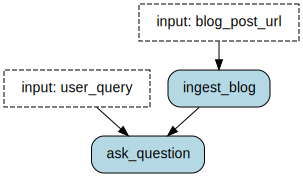

In [10]:
# "instrumenting" patches the libraries to log OpenTelemetry data
# from opentelemetry.instrumentation.lancedb import LanceInstrumentor
# from opentelemetry.instrumentation.openai import OpenAIInstrumentor

# OpenAIInstrumentor().instrument()
# LanceInstrumentor().instrument()

app_v2 = (
    ApplicationBuilder()
    .with_actions(ingest_blog=ingest_blog_v2, ask_question=ask_question_v2)
    .with_transitions(("ingest_blog", "ask_question"))
    .with_entrypoint("ingest_blog")
    # enable the tracker and enable OpenTelemetry via the argument
    .with_tracker(project="modular-rag", use_otel_tracing=True)
    .build()
)
app_v2

In [11]:
action_name, results, state = app_v2.run(
    halt_after=["ask_question"],
    inputs={
        "blog_post_url": "https://blog.dagworks.io/p/from-blog-to-bot-build-a-rag-app",
        "user_query": "What do you need to monitor in a RAG app?"
    }
)
print(state["llm_answer"])

In a RAG application, you need to monitor the following aspects:

1. **User Behavior Patterns**: This includes frequent topics and difficult queries that users engage with.
2. **Application Performance**: You should track metrics such as guardrails, LLM randomness, and user ratings.
3. **System Performance**: Monitor system metrics like latency, throughput, resource usage, and API calls.
4. **System Errors**: Keep an eye on bugs that may arise from code or the interaction between code and data.


In [12]:
# execute cell to launch the UI
%burr_ui

Burr UI: http://127.0.0.1:7241


By navigating to the `modular-rag` project, you can see logged runs. With OpenTelemetry support, we can inspect the LanceDB operations and the OpenAI calls. For instance, this allows us to see which were the relevant chunks retrieved and passed to the LLM.

![image.png](burr_ui_app_v2.png)

The Burr UI has other useful features:
- view token usage
- annotate state values and logged attributes
- create test fixtures from application state
- and more 
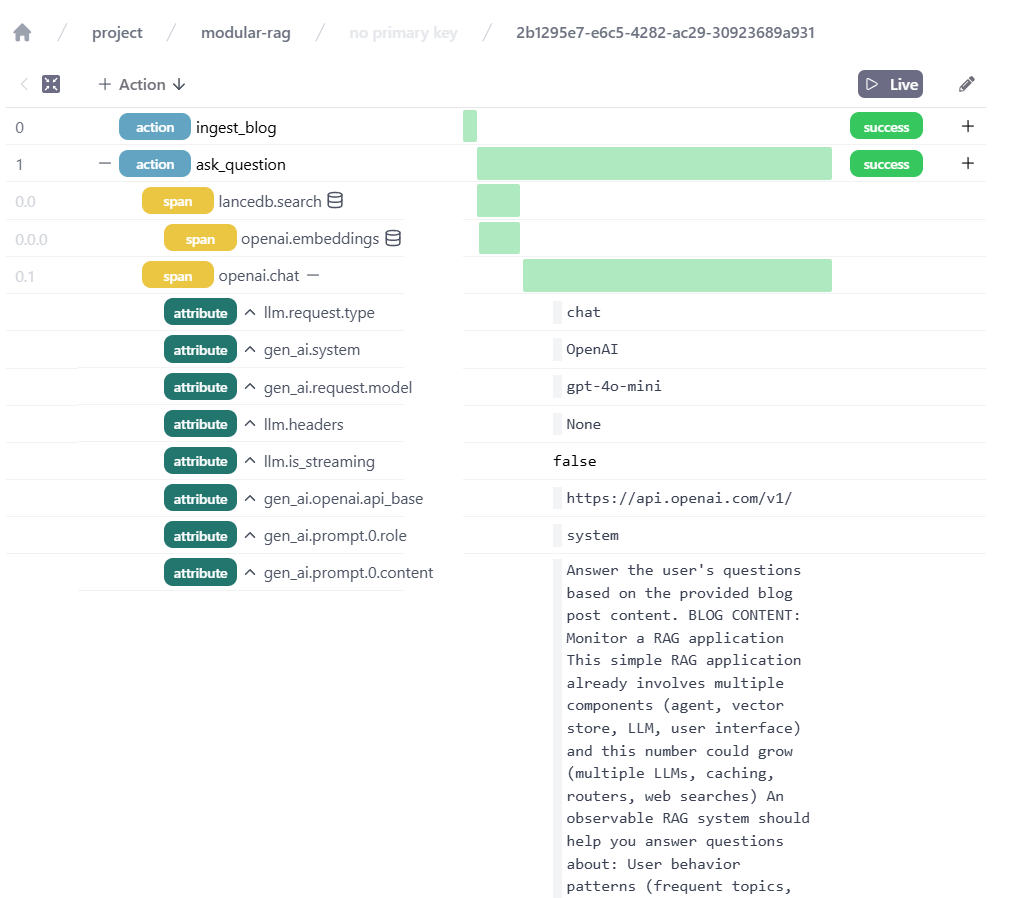

## V3: Keeping your code modular

You probably noticed that actions functions in `V2` started to be long and do several things. It would be a good time to refactor them into smaller functions for easier development and maintenance. Again, those would be improvement at the layer 1.

### Layer 1: Modular actions

In th next snippets, we refactor actions using Hamilton, a lightweight library to structure data transformations as directed acyclic graphs (DAGs). Hamilton uses the function and parameter names to infer the dependencies between functions and the graph structure.

The next cell reimplements the `ingest_blog` action from `V2`. It uses `%%cell_to_module` from the Hamilton notebook extension to define a DAG in a single cell and view it ([see tutorial](https://github.com/DAGWorks-Inc/hamilton/blob/main/examples/jupyter_notebook_magic/example.ipynb)).

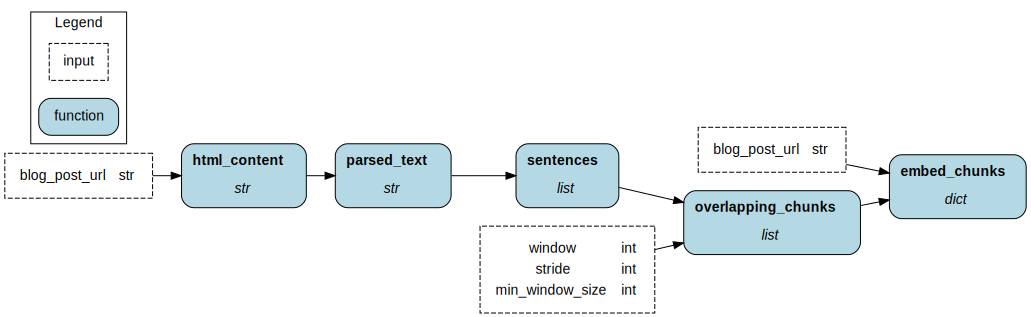

In [13]:
%%cell_to_module ingest_blog --display
import re
import requests
import lancedb
from bs4 import BeautifulSoup
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry


embedding_model = get_registry().get("openai").create()

class TextDocument(LanceModel):
    """Simple data structure to hold a piece of text associated with a url."""
    url: str
    position: int
    text: str = embedding_model.SourceField()
    vector: Vector(dim=embedding_model.ndims()) = embedding_model.VectorField()


def html_content(blog_post_url: str) -> str:
    return requests.get(blog_post_url).text


def parsed_text(html_content: str) -> str:
    soup = BeautifulSoup(html_content, "html.parser")
    return soup.get_text(separator=" ", strip=True)
    

def sentences(parsed_text: str) -> list[str]:
    return [
        sentence.strip()
        for sentence in re.split(r"[.!?]+", parsed_text)
        if sentence.strip()
    ]


def overlapping_chunks(
    sentences: list[str],
    window: int = 5,
    stride: int = 3,
    min_window_size: int = 2
) -> list[str]:
    overlapping_chunks = []
    n_chunks = len(sentences)
    for start_i in range(0, n_chunks, stride):
        if (start_i + window <= n_chunks) or (n_chunks - start_i >= min_window_size):
            overlapping_chunks.append(" ".join(sentences[start_i : min(start_i + window, n_chunks)]))
    return overlapping_chunks


def embed_chunks(overlapping_chunks: list[str], blog_post_url: str) -> dict:
    # embed and store the chunks using LanceDB
    con = lancedb.connect("./blogs")
    table = con.create_table("chunks", exist_ok=True, schema=TextDocument)
    table.add([
        {"text": c, "url": blog_post_url, "position": i}
        for i, c in enumerate(overlapping_chunks)
    ])
    return {"n_chunks_embedded": len(overlapping_chunks)}

While this may seem trivial, these simple functions are easier to test, debug, and modify. It also allows us to develop and test actions outside of Burr. Hamilton has a great caching feature that can speed up development significantly when iterating over your application.

Here, we create a `Driver` from the `ingest_blog` module we defined and enable caching.

In [14]:
from hamilton.driver import Builder

ingest_dr = Builder().with_modules(ingest_blog).with_cache().build()

Then, we request the `sentences` node to inspect results. This way, the `embed_chunks` node won't be executed and we won't spend time/credits on computing embeddings during development

In [15]:
results = ingest_dr.execute(
    ["sentences"],
    inputs={"blog_post_url": "https://blog.dagworks.io/p/building-a-better-feature-platform"},
)
print(results["sentences"][17])

We evaluated and completed proof-of-concepts with the top five commercial and open-source providers in the market


Next, we implement the `ask_question` action with Hamilton.

We encourage considering prompt as code, which allows us to commit and version our prompt with the rest of our code. For instance, the function `system_prompt()` helps understand what information goes into the prompt and an additional docstring can add context to it ([related blog](https://blog.dagworks.io/p/llmops-production-prompt-engineering)).

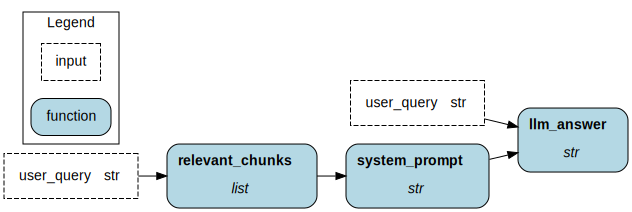

In [16]:
%%cell_to_module ask_question --display
import openai
import lancedb

def relevant_chunks(user_query: str) -> list[dict]:
    chunks_table = lancedb.connect("./blogs").open_table("chunks")
    search_results = (
        chunks_table
        .search(user_query)
        .select(["text", "url", "position"])
        .limit(3)
        .to_list()
    )
    return search_results


def system_prompt(relevant_chunks: list[dict]) -> str:
    relevant_content = "\n".join([c["text"] for c in relevant_chunks])
    return (
        "Answer the user's questions based on the provided blog post content. "
        "Answer in a concise and helpful manner, and tell the user "
        "if you don't know the answer or you're unsure.\n\n"
        f"BLOG CONTENT:\n{relevant_content}"
    )

def llm_answer(system_prompt: str, user_query: str) -> str:
    client = openai.OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_query}
        ],
    )
    return response.choices[0].message.content

### Layer 2: Using Hamilton with Burr

Since Burr is not opinionated about the implementation of `@action` functions, you can simply call Hamilton from it. We add the `OpenTelemetryTracer` to the Hamilton `Driver` to get tracing in Burr UI.

You'll see that the Layer 2 becomes much lighter and only the high-level logic remains.

In [17]:
from hamilton.driver import Builder
from hamilton.plugins.h_opentelemetry import OpenTelemetryTracer
from burr.core import action, State, ApplicationBuilder

# these imports will only work if you executed the cells that
# defines them using the `%%cell_to_module` magic 
import ingest_blog
import ask_question


@action(reads=[], writes=[])
def ingest_blog_v3(state: State, blog_post_url: str) -> State:
    """Download a blog post and parse it"""
    dr = (
        Builder()
        .with_modules(ingest_blog)
        .with_adapters(OpenTelemetryTracer())
        .build()
    )
    dr.execute(["embed_chunks"], inputs={"blog_post_url": blog_post_url}) 
    return state


@action(reads=[], writes=["llm_answer"])
def ask_question_v3(state: State, user_query: str) -> State:
    """Reply to the user's query using the blog's content."""
    dr = (
        Builder()
        .with_modules(ask_question)
        .with_adapters(OpenTelemetryTracer())
        .build()
    )
    results = dr.execute(["llm_answer"], inputs={"user_query": user_query}) 
    return state.update(llm_answer=results["llm_answer"])

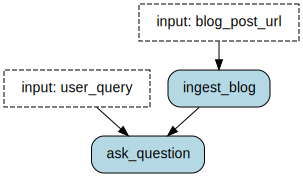

In [18]:
app_v3 = (
    ApplicationBuilder()
    .with_actions(ingest_blog=ingest_blog_v3, ask_question=ask_question_v3)
    .with_transitions(("ingest_blog", "ask_question"))
    .with_entrypoint("ingest_blog")
    .with_tracker(project="modular-rag", use_otel_tracing=True)
    .build()
)
app_v3

In [19]:
action_name, results, state = app_v2.run(
    halt_after=["ask_question"],
    inputs={
        "blog_post_url": "https://blog.dagworks.io/p/from-blog-to-bot-build-a-rag-app",
        "user_query": "What do you need to monitor in a RAG app?"
    }
)
print(state["llm_answer"])

This is trying to return without having computed a single action -- we'll end up just returning some Nones. This means that nothing was executed (E.G. that the state machine had nowhere to go). Either fix the state machine orthe halt conditions, or both... Halt conditions are: halt_before=[], halt_after=['ask_question'].Note that this is considered undefined behavior -- if you get here, you should fix!


In a RAG application, you need to monitor the following aspects:

1. **User Behavior Patterns**: This includes frequent topics and difficult queries that users engage with.
2. **Application Performance**: You should track metrics such as guardrails, LLM randomness, and user ratings.
3. **System Performance**: Monitor system metrics like latency, throughput, resource usage, and API calls.
4. **System Errors**: Keep an eye on bugs that may arise from code or the interaction between code and data.


The biggest benefit of Burr + Hamilton is the unbeatable observability you get. The Burr UI will show a granular breakdown of the operations.

![image.png](burr_ui_app_v3.png)

Hamilton even has its dedicated [Hamilton UI](https://hamilton.dagworks.io/en/latest/hamilton-ui/ui/) that tracks execution, catalogs data transformations, and provides in-depth introspection. We're looking to integrate the two further together!

![image.png](hamilton_ui.png)

Actually, two tricks can help simplify the code:
- Build a single `Driver` from both action modules
- Pass the `Driver` as an `@action` input using `.bind()` instead of building the `Driver` each time

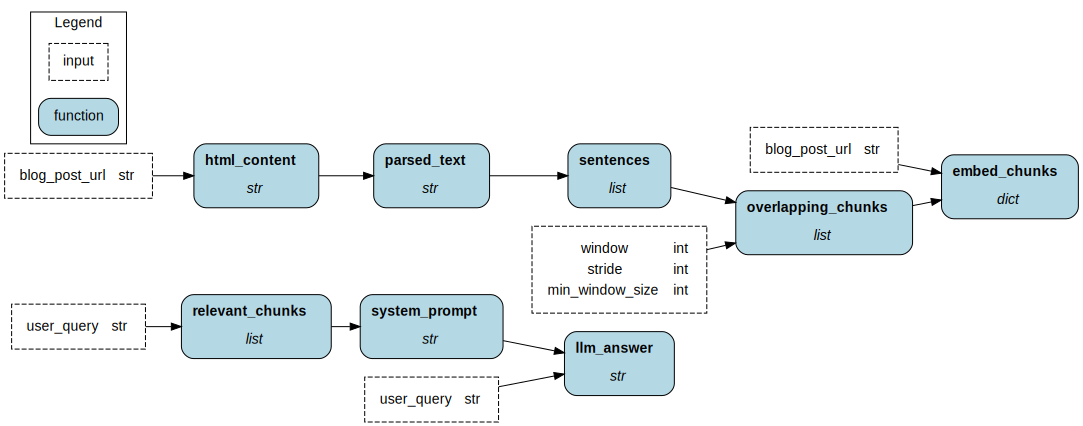

In [20]:
dr = Builder().with_modules(ingest_blog, ask_question).with_adapters(OpenTelemetryTracer()).build()
dr

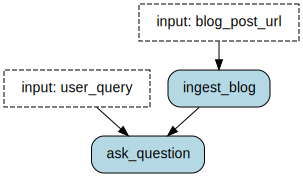

In [21]:
from hamilton.driver import Driver, Builder
from burr.core import action, State, ApplicationBuilder


@action(reads=[], writes=[])
def ingest_blog_v3_2(state: State, blog_post_url: str, dr: Driver) -> State:
    """Download a blog post and parse it"""
    dr.execute(["embed_chunks"], inputs={"blog_post_url": blog_post_url}) 
    return state


@action(reads=[], writes=["llm_answer"])
def ask_question_v3_2(state: State, user_query: str, dr: Driver) -> State:
    """Reply to the user's query using the blog's content."""
    results = dr.execute(["llm_answer"], inputs={"user_query": user_query}) 
    return state.update(llm_answer=results["llm_answer"])


app_v3_2 = (
    ApplicationBuilder()
    .with_actions(
        ingest_blog=ingest_blog_v3_2.bind(dr=dr),
        ask_question=ask_question_v3_2.bind(dr=dr)
    )
    .with_transitions(("ingest_blog", "ask_question"))
    .with_entrypoint("ingest_blog")
    .build()
)
app_v3_2

## Conclusion

We presented the 2-layer approach to building a RAG application, which separates the high-level logic from the implementation of individual actions.

The key lesson is that you should adopt frameworks incrementally. A tool shouldn't lock you in and limit the evolution of your application. Adopting Burr from the start helps you develop in a principled way, and adding Hamilton as the complexity increases helps create a maintainable application.  